In [1]:
# The idea is to do a simple linear model of non-linear interactions between basic statistics. We will motivate these
# interactions based on some intuitions. For example, (mean / std) should influence the forecasting ability 
# different statistics, i.e. look at (mean / std) * mean. However, we do this for windows.

# A better basis is based on using r_i = (mean_window_i / mean_all) or r_i = (mean_window_i / (epsilon + mean_all)).
# Normally, one could estimate using the average of the mean_window_i (or some weighted average). However, when 
# r_i is large, one wants to replace mean_window_i by mean_all. So we are lead to trying basis functions such as
# f_i = exp(-K_i * r_i) * mean_window_i + (1 - exp(-K_i * r_i)) * mean_all, where K_i is a constant parameter that
# can be adjusted. First try finding optimal K_i that increase linear correlation between Y_mean and f_i.
# Also can try using logit functions of r_i or some other functions that is suggestive of a neural network.

# Note that key_1.csv shows that we are supposed to predict about 2 months worth of future data based on data
# lasting from 2015-07-01 to 2016-12-31.

In [2]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import (train_test_split, cross_val_score)
from sklearn.preprocessing import (PolynomialFeatures, FunctionTransformer, StandardScaler)
from sklearn.pipeline import (make_pipeline, make_union, Pipeline, FeatureUnion)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor

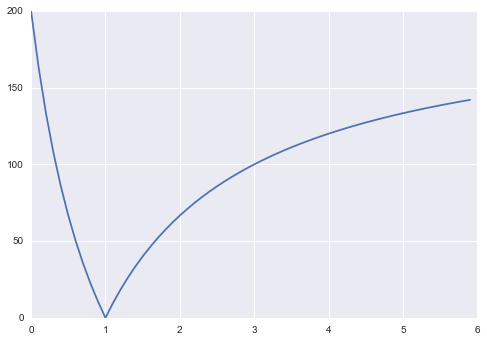

In [3]:
# Reference for performace measured by reference function. For a term |y_test - y_predict| / (|y_test| + |y_predict|) * 2 * 100,
# we look at when y_predict = alpha * y_test. Look at term as a function of alpha.

alpha = np.arange(0.0, 6.0, 0.1)
num = np.abs(1 - alpha)
denom = 1 + np.abs(alpha)
smapeVals = num / denom * 2 * 100

plt.plot(alpha, smapeVals)
plt.show()

In [4]:
all_df = pd.read_csv('train_1.csv')
all_df.shape

(145063, 551)

In [5]:
# For now, just set all NaN to 0.

all_df.fillna(0, inplace = True)

In [6]:
futureT = 64

X_all = all_df.drop('Page', axis = 1).values[:, :-futureT]
Y_all = all_df.drop('Page', axis = 1).values[:, -futureT:]

In [7]:
X_trainvalid, X_test, Y_trainvalid, Y_test = train_test_split(X_all, Y_all, test_size = 0.33, random_state = 32)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_trainvalid, Y_trainvalid, test_size = 0.33, random_state = 35)

print('X_train.shape = ', X_train.shape, '\tX_valid.shape = ', X_valid.shape, '\tX_test.shape = ', X_test.shape)
print('Y_train.shape = ', Y_train.shape, '\tY_valid.shape = ', Y_valid.shape, '\tY_test.shape = ', Y_test.shape)

X_train.shape =  (65118, 486) 	X_valid.shape =  (32074, 486) 	X_test.shape =  (47871, 486)
Y_train.shape =  (65118, 64) 	Y_valid.shape =  (32074, 64) 	Y_test.shape =  (47871, 64)


In [128]:
def smape(Y_predict, Y_test):
    result = np.linalg.norm(Y_predict - Y_test, axis = 1)
    result = np.abs(result)
    denom = np.linalg.norm(Y_predict, axis = 1)
    denom += np.linalg.norm(Y_test, axis = 1)
    result /= denom
    result *= 100 * 2
    result = np.mean(result)
    return result

def smape_scorer(estimator, X, Y):
    Ypredict = estimator.predict(X)
    result = smape(Y, Ypredict)
    return -result

def window_features(X, nWindows = 2, windowSize = 64):
    nSamples, nFeatures = X.shape
    # Make a view from X that is a 3d array of size (nSamples, windowSize, nWindows). This gives a view
    # of each window in X.
    X_window = nFeatures - 1 - np.arange(windowSize)[:, np.newaxis] - windowSize * np.arange(nWindows)
    X_window = X[:, X_window]
    
    # Now extract features for X and for each window.
    all_mean = np.mean(X, axis = 1, keepdims = True)
    features = all_mean.copy()
    newCols = np.mean(X_window, axis = 1) # window means
    features = np.hstack((features, newCols))
    
    return features

def window_weights(all_mean, window_means, k = 1, epsilon = 1e-6):
    weights = window_means / (epsilon + all_mean)
    weights = np.exp(-k * weights)
    return weights
    
def all_features(X, nWindows = 2, windowSize = 64, k = 1, epsilon = 1e-4):
    nSamples, nTimes = X.shape
    windFeatures = window_features(X, nWindows, windowSize)
    weights = window_weights(windFeatures[:,0].reshape(-1,1), windFeatures[:, 1:1+nWindows], k, epsilon)
    weightedFeatures = windFeatures[:, :, np.newaxis] * weights[:, np.newaxis, :]
    weightedFeatures = weightedFeatures.reshape(nSamples, -1)
    windFeatures = np.hstack((windFeatures, weightedFeatures))
    return windFeatures

In [135]:
# Look at feature data.

newFeatures = window_features(X_train)
weights = window_weights(newFeatures[:, 0].reshape(-1,1), newFeatures[:, 1:3])
allFeatures = all_features(X_train)
print('newFeatures.shape = ', newFeatures.shape, '\tweights.shape = ', weights.shape, '\tallFeatures.shape = ', allFeatures.shape)

newFeatures.shape =  (65118, 3) 	weights.shape =  (65118, 2) 	allFeatures.shape =  (65118, 9)


(65118, 6)


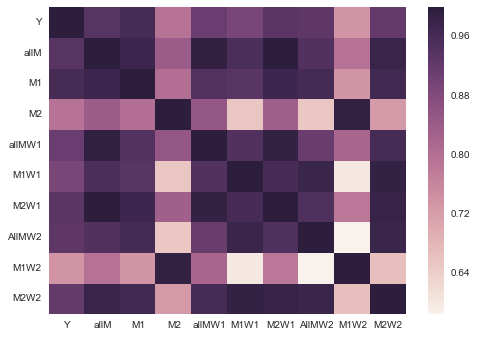

In [130]:
# Let's look at linear correlations.
nSamples, nTimes = X_train.shape
Y_mean = Y_train.mean(axis = 1, keepdims = True)
weightFeatures = newFeatures[:, :, np.newaxis] * weights[:, np.newaxis, :]
weightFeatures = weightFeatures.reshape((nSamples, -1))
print(weightFeatures.shape)
corr_vars = np.hstack((Y_mean, newFeatures, weightFeatures)).T
corr_names = ['Y', 'allM', 'M1', 'M2', 'allMW1', 'M1W1', 'M2W1', 'AllMW2', 'M1W2', 'M2W2']
corr_matrix = np.corrcoef(corr_vars)
sns.heatmap(corr_matrix, xticklabels = corr_names, yticklabels = corr_names)
plt.show()

In [138]:
# Now let's look at a simple linear models.

# First just the window features.

model = Pipeline([ ('pre', FunctionTransformer(window_features)),
                   ('linear', LinearRegression()) ])
scores = - cross_val_score(model, X_train, Y_train, scoring = smape_scorer)
print('Just window features:\nCross val score = ', scores.mean(), '+-', scores.std())

# Now weighted features.

model = Pipeline([ ('pre', FunctionTransformer(all_features)),
                   ('linear', LinearRegression()) ])
scores = - cross_val_score(model, X_train, Y_train, scoring = smape_scorer)
print('Including weighted window features:\nCross val score = ', scores.mean(), '+-', scores.std())

# Now just use high linear correlations.
model = Pipeline([ ('pre', FunctionTransformer(all_features)),
                   ('highcorr', FunctionTransformer(lambda X: X[:, [0,1,5,8]])),
                   ('linear', LinearRegression()) ])
scores = - cross_val_score(model, X_train, Y_train, scoring = smape_scorer)
print('Including weighted window features:\nCross val score = ', scores.mean(), '+-', scores.std())

Just window features:
Cross val score =  124.250165845 +- 4.26721395276
Including weighted window features:
Cross val score =  130.887036909 +- 2.97528593841
Including weighted window features:
Cross val score =  127.947999872 +- 3.63557538208
